Learnings

- Explore sklearn preprocessing tools
- Data processing takes forever


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
train_file = '/home/rushi/dev/data/housing/train.csv'
test_file = '/home/rushi/dev/data/housing/test.csv'
hd = pd.read_csv(train_file)

In [4]:
# parse the data dictionary

class Desc(object):
    def __init__(self, name, desc, desc_dict=None):
        self.desc_dict = desc_dict
        self.desc = desc
        self.name = name
        
    def add(self, val, val_desc):
        if self.desc_dict is None:
            self.desc_dict = {}
        self.desc_dict[val] = str(val) + '_' + val_desc
        
    def __repr__(self):
        ret = f'{self.name}: {self.desc} Quant: {self.desc_dict is None} '
        if self.desc_dict is not None:            
            ret +='\n'
            ret +='\n'.join([f'{k}: {v}' for k,v in self.desc_dict.items()])
        return ret
        
data_txt_file = '/home/rushi/dev/data/housing/data_description.txt'

data_dict = {}
data_dict['Id'] = Desc('Id', 'Index')
with open(data_txt_file, 'r') as f:
    curr_col = None
    for line in f.readlines():
        
        if line.strip() == '':
            # empty lines
            continue
            
        elif ':' in line.split(' ')[0]:
            # we are in a new column/description
            col_name, col_desc = line.split(':')
            curr_col = col_name
            data_dict[curr_col] = Desc(col_name, col_desc)
            
        else:
            # we are in column details
            line_splits = line.strip().split('\t')            
            val, val_desc = line_splits[0].strip(), ' '.join(line_splits[1:])            
            data_dict[curr_col].add(val, val_desc)

data_dict['SalePrice'] = Desc('SalePrice', 'Y')
cols = list(data_dict.keys())

assert len(data_dict) == len(hd.columns)
for v1, v2 in zip(data_dict.keys(), hd.columns):
    assert v1 == v2, (v1, v2)

In [5]:
import functools

def one_hot_encode(x, keys):
    x = str(x)
    res = np.zeros(len(keys))
    try:
        res[keys.index(x)] = 1
    except:
        # data has both of these descriptions.
        exceptions_map = {'C (all)' : 'C', 'Wd Shng': 'WdShing', 'WdShngl': 'WdShing',
                         'CmentBd' : 'CemntBd', 'Brk Cmn' : 'BrkComm', 'NA': 'None'}
        if x in exceptions_map.keys():
            x = exceptions_map[x]
    
        try:
            res[keys.index(x)] = 1
        except:
            # all zeros
            pass
    return res

converters_v1 = {}

for name, pred in data_dict.items():
    if pred.desc_dict is not None:  
       
        # create one hot encoding for qualitative inputs        
        keys = list(pred.desc_dict.keys())
        converters_v1[name] = functools.partial(one_hot_encode, keys=keys)
nhd = pd.read_csv(train_file, converters=converters_v1)

In [24]:
from itertools import repeat

# TODO: use basic target encoding
# TODO: Lookup bayesian target encoding

def ordinal_encode(x, keys):    
    return keys.index(x)

ordinal_keys = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
                'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
                'GarageQual', 'GarageCond', 'PoolQC'] + ['BsmtFinType1', 'BsmtFinType2', 'GarageFinish']

converters_v2 = {}

is_one_hot = []  # Bad name. should be is_not_one_hot
for name, pred in data_dict.items():
    
    if pred.desc_dict is not None:  
        
        # create one hot encoding for qualitative inputs        
        
        if name in ordinal_keys:            
            # reversed iterators since the values look [Good, Avg, Bad] and we want higher values for better quality
            # i.e we want +ve correlations with these predictors
            keys = list(reversed(list(pred.desc_dict.keys()) + ["NA"])) # Some test data does not have values
            converters_v2[name] = functools.partial(ordinal_encode, keys=keys)
            is_one_hot.append(1)
        else:
            keys = list(pred.desc_dict.keys())        
            converters_v2[name] = functools.partial(one_hot_encode, keys=keys)
            is_one_hot.extend([0] * len(keys))
    else:
        is_one_hot.append(1)

nhd_v2 = pd.read_csv(train_file, converters=converters_v2)
nhd_test = pd.read_csv(test_file, converters=converters_v2)

In [25]:
# Important: Convert to np arrays
def get_fdata(np_array):    
    rows = []
    for ii in np_array:
        row = np.array([], dtype=np.float64)
        for jj in ii:
            row = np.append(row, jj)
        rows.append(row)        
    return rows

fdata = np.concatenate([get_fdata(nhd.to_numpy())])
fdata_v2 = np.concatenate([get_fdata(nhd_v2.to_numpy())])
fdata_test = np.concatenate([get_fdata(nhd_test.to_numpy())])
fdata.shape, fdata_v2.shape, fdata_test.shape

((1460, 356), (1460, 274), (1459, 273))

In [26]:
# Get full axis values
full_axis = []
for key, value in data_dict.items():
    if value.desc_dict is not None:
        full_axis.extend([f'{key}_{x}'.replace(' ', '_') for x in value.desc_dict.values()])
    else:
        full_axis.append(value.name)
full_axis = np.array(full_axis)
print(full_axis[:5], full_axis.shape)

['Id' 'MSSubClass_20_1-STORY_1946_&_NEWER_ALL_STYLES'
 'MSSubClass_30_1-STORY_1945_&_OLDER'
 'MSSubClass_40_1-STORY_W/FINISHED_ATTIC_ALL_AGES'
 'MSSubClass_45_1-1/2_STORY_-_UNFINISHED_ALL_AGES'] (356,)


In [27]:
# Get full axis values v2
full_axis_v2 = []
for key, value in data_dict.items():
    if value.desc_dict is not None and key not in ordinal_keys:
        full_axis_v2.extend([f'{key}_{x}'.replace(' ', '_') for x in value.desc_dict.values()])
    else:
        full_axis_v2.append(value.name)
full_axis_v2 = np.array(full_axis_v2)
print(full_axis_v2[:5], full_axis_v2.shape)

['Id' 'MSSubClass_20_1-STORY_1946_&_NEWER_ALL_STYLES'
 'MSSubClass_30_1-STORY_1945_&_OLDER'
 'MSSubClass_40_1-STORY_W/FINISHED_ATTIC_ALL_AGES'
 'MSSubClass_45_1-1/2_STORY_-_UNFINISHED_ALL_AGES'] (274,)


In [60]:
def manual_clean(data, x_axis, is_train=True):
    # Replace index with intercept
    x = data[:,:-1].copy() if is_train else data.copy()# remove y
    x[:,0] = np.ones(x.shape[0]) # replace index with intercept
    data_dict['Id'] = Desc('Intercept', 'Intercept')
    data_dict['Id']
    x_axis = x_axis[:-1] # remove y 
    y = fdata[:,-1].copy() if is_train else None

    # MANUAL CLEANING
    lot_frontage_idx = x_axis.tolist().index('LotFrontage')
    mas_vnr_idx = x_axis.tolist().index('MasVnrArea')
    gbuilt_idx = x_axis.tolist().index('GarageYrBlt')
    ybuilt_idx = x_axis.tolist().index('YearBuilt')
    x[np.isnan(x[:, lot_frontage_idx]), lot_frontage_idx] = 0 # set lot frontage to 0 when unavailable
    x[np.isnan(x[:, mas_vnr_idx]), mas_vnr_idx] = 0 # set masonry veneer area to 0 when unavailable
    x[:, gbuilt_idx] = np.where(np.isnan(x[:, gbuilt_idx]), x[:, ybuilt_idx], x[:, gbuilt_idx]) # when garage built year unknown, use year property built
    
    return x, y, x_axis

x_v1, y_v1, axis_v1 = manual_clean(fdata, full_axis)
x_v2, y_v2, axis_v2 = manual_clean(fdata_v2, full_axis_v2)
x_rtest, y_rtest, axis_rtest = manual_clean(fdata_test, full_axis_v2)

In [61]:
# VIEW data
def dr(data, axis): # describe row
    return {x: v for x,v in zip(axis, data)}

In [62]:
def split_data(x, y):    
    test_idx = int(x.shape[0] * 0.8) + 1
    x_train = x[:test_idx, : ]
    y_train = y[:test_idx]
    x_test = x[test_idx:, :]
    y_test = y[test_idx:]
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_data(x_v1, y_v1)
x2_train, y2_train, x2_test, y2_test = split_data(x_v2, y_v2)

# Normalized data

# Data Version 3 is normalized values for quantitative X values
# Y is scaled down by 1e4
y3_scale = 1e4
y_v3 = y_v2.copy() / y3_scale

x_v3 = x_v2.copy()
axis_v3 = axis_v2.copy()

is_one_hot_np = np.array(is_one_hot[:-1]) # ignore intercept column for one_hot and y column
quant_indices = np.where(is_one_hot_np > 0)
quant_indices_x = quant_indices[0][1:]
assert (is_one_hot_np.shape[0] == x_v2.shape[1])

def normalize_all(x_o, x_train):
    x = x_o.copy()
    for idx in quant_indices_x:        
        x[:, idx] = (x[:, idx] - np.mean(x_train[:, idx]))/np.sqrt((np.var(x_train[:, idx])))
    return x

x3_train_o, y3_train, x3_test_o, y3_test = split_data(x_v3, y_v3)

x3_train = normalize_all(x3_train_o, x3_train_o)
x3_test = normalize_all(x3_test_o, x3_train_o)
x_rtest = normalize_all(x_rtest, x3_train_o)

# Normalization Test
idx = axis_v3.tolist().index('GrLivArea')
print(np.sum(x3_train[:, idx]), np.sum(x3_test[:, idx]), np.sum(x_rtest[:, idx]))

1.3145040611561853e-13 37.09446025822451 -47.67311227516237


In [65]:
from sklearn import linear_model

# Fit on a single variable
lot_frontage_idx = full_axis.tolist().index('LotFrontage')
LR = linear_model.LinearRegression(fit_intercept=False)
x_train_int = x_train[:, [0,lot_frontage_idx]]
res = LR.fit(x_train_int, y_train)
print(f"Coef: {res.coef_}")
print("Train score: {} Test score: {}".format(res.score(x_train_int, y_train), res.score(x_test[:, [0, lot_frontage_idx]], y_test)))

# Fit on everything
LR = linear_model.LinearRegression(fit_intercept=False)
res_full_fit = LR.fit(x_train, y_train)
res_full_fit.score(x_test, y_test)
print("Train score: {} Test score: {}".format(res_full_fit.score(x_train, y_train), res_full_fit.score(x_test, y_test)))

Coef: [150462.09068574    523.28709799]
Train score: 0.051491390319412966 Test score: 0.013990042282039816
Train score: 0.9395495195087282 Test score: 0.6633091689051294


In [69]:
import scipy.stats
def get_corrs(x,y):

    # Find the most correlated variables
    def corr(x):
        return scipy.stats.pearsonr(x, y)
    corrs = np.apply_along_axis(corr, 0, x).T
    corrs[np.isnan(corrs)] = 0
    corrs = corrs[:,0] # ignore the p value
    return corrs

corrs = get_corrs(x_train, y_train)
corrs_v2 = get_corrs(x2_train, y2_train)
corrs_v3 = get_corrs(x3_train, y3_train)

# largest corrs
largest_corrs = np.argsort(-np.abs(corrs)) # -corrs since argsort sorts from min to max and we want largest corr
largest_corrs_v2 = np.argsort(-np.abs(corrs_v2))
largest_corrs_v3 = np.argsort(-np.abs(corrs_v3))

#dr(corrs[largest_corrs], axis_v1[largest_corrs])
#dr(corrs_v2[largest_corrs_v2], axis_v2[largest_corrs_v2])
#dr(corrs_v3[largest_corrs_v3], axis_v3[largest_corrs_v3])

In [73]:
def fit(x_train, y_train, x_test, y_test):
    LR = linear_model.LinearRegression(fit_intercept=True)
    res = LR.fit(x_train, y_train)    
    return res.score(x_train, y_train), res.score(x_test, y_test), res

print("base top 20", fit(x_train[:, largest_corrs[:20]], y_train, x_test[:, largest_corrs[:20]], y_test))
print("v2 top 20", fit(x2_train[:, largest_corrs_v2[:20]], y2_train, x2_test[:, largest_corrs_v2[:20]], y2_test))
print("v2 top 140", fit(x2_train[:, largest_corrs_v2[:140]], y2_train, x2_test[:, largest_corrs_v2[:140]], y2_test))

print("v3 top 20", fit(x3_train[:, largest_corrs_v3[:20]], y3_train, x3_test[:, largest_corrs_v3[:20]], y3_test))
print("v3 top 140", fit(x3_train[:, largest_corrs_v3[:140]], y3_train, x3_test[:, largest_corrs_v3[:140]], y3_test))

print("v2 all", fit(x2_train, y2_train, x2_test, y2_test)) # TODO: needs explanation
print("v3 all", fit(x3_train, y3_train, x3_test, y3_test)) # TODO: needs explanation

# Look at the coeffecients since it gives information about actual influece in a combined setting.
# Especially since all of the inputs are now normalized.
#num_preds = None
#_,_,res = fit(x3_train[:, largest_corrs_v3[:num_preds]], y3_train, x3_test[:, largest_corrs_v3[:num_preds]], y3_test)
#dr(res.coef_, axis_v3[largest_corrs_v3[:num_preds]]), res.intercept_
# The coeffecients explode after the first  20 or so predictors.
# This is likely because they are heavily offset by the other predictors in the one-hot group.

base top 20 (0.8357951195579905, 0.633514671565675, LinearRegression())
v2 top 20 (0.8262935096544097, 0.6575572381355508, LinearRegression())
v2 top 140 (0.9083324699290795, 0.7096104843892723, LinearRegression())
v3 top 20 (0.8262935096544098, 0.6575572381355501, LinearRegression())
v3 top 140 (0.9077744307987841, 0.7108541562776536, LinearRegression())
v2 all (0.9253331622758502, -5236938.480691137, LinearRegression())
v3 all (0.9253371712961918, -7.447342444841612e+17, LinearRegression())


In [74]:
# TODO: Can we weight these observations somehow ?

def regress(x, y, reg_lambda=0):
    xT = x.T
    xTx = xT @ x
    xTy = xT @ y
    #xTx_inv = np.linalg.solve(xTx, np.eye(xTx.shape[0])) # singular
    xTx_inv  = np.linalg.solve(xTx + reg_lambda * np.eye(xTx.shape[0]), np.eye(xTx.shape[0])) # regularized
    B = xTx_inv @ xTy
    return B, xTx_inv

# yhat = xTy
def pred(B, x):
    return x @ B

# R^2 score
def r2(yhat, y):
    tss = np.sum((y - np.mean(y)) ** 2)
    rss = np.sum((yhat - y) ** 2)
    return 1 - (rss/tss)

# sigma_squared_hat (noise variance estimate - mean 0)
def est_noise_var(y, yhat, num_samples, num_preds):
    return 1/(num_samples - num_preds - 1) * np.sum((y - yhat) ** 2)

def z_scores(B, B_var):
    return B/np.sqrt(np.diag(xTx_inv))

def metrics(y, yhat):
    mse = np.sum((y - yhat)**2)/y.shape[0]
    base_rate = np.sum((y - np.mean(y))**2)/y.shape[0]
    mean_abs_error = np.sum(np.abs(y - yhat))/y.shape[0]
    return {'mse' : mse,
            'base_rate' : base_rate,
            'reduction' : (base_rate - mse)/base_rate,
            'mae' : mean_abs_error
           }

#import scipy.stats
#T_dist = scipy.stats.t(df = x_train.shape[0])
#T_dist.isf(0.05)

In [134]:
from IPython.display import display
B, xTx_inv = regress(x3_train, y3_train, 0.0001)

yhat_test = pred(B, x3_test)
yhat_train = pred(B, x3_train)
noise_var = est_noise_var(y3_train, yhat_train, x3_train.shape[0], x3_train.shape[1])
B_var = xTx_inv * noise_var
z_scores = z_scores(B, B_var)
print("R2 score: Test: {} Train: {}".format(r2(yhat_test, y3_test), r2(yhat_train, y3_train)))
print("Noise Var: ", noise_var)


R2 score: Test: 0.6639029061333876 Train: 0.9253491879296507
Noise Var:  6.049019358790915


In [ ]:
# Predictors with Z scores with p<0.05


In [27]:
def display(x, y, corrs, axis):
    plt.rcParams['figure.figsize'] = [40, 10]

    num_rows = 3
    num_columns = 5
    fig, ax = plt.subplots(num_rows, num_columns)
    for idx, ii in enumerate(corrs[:num_rows * num_columns]):
        sub_plot = ax[idx // num_columns, idx % num_columns]
        sub_plot.plot(x[:, ii], y, '.')
        sub_plot.set_xlabel(str(axis[ii]))    

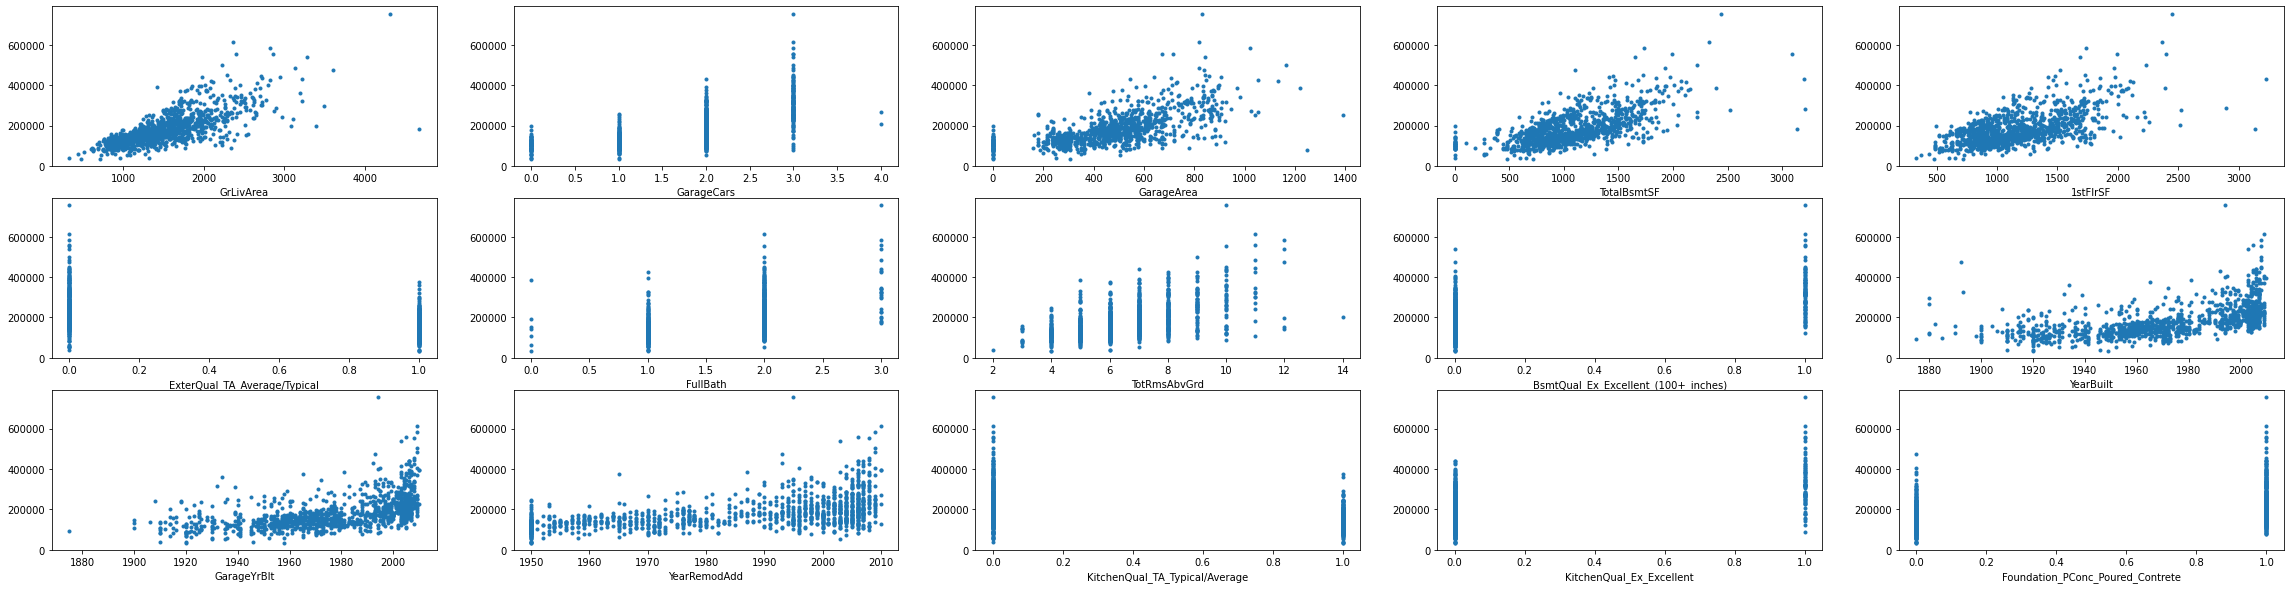

In [28]:
display(x_train, y_train, largest_corrs, axis_v1)

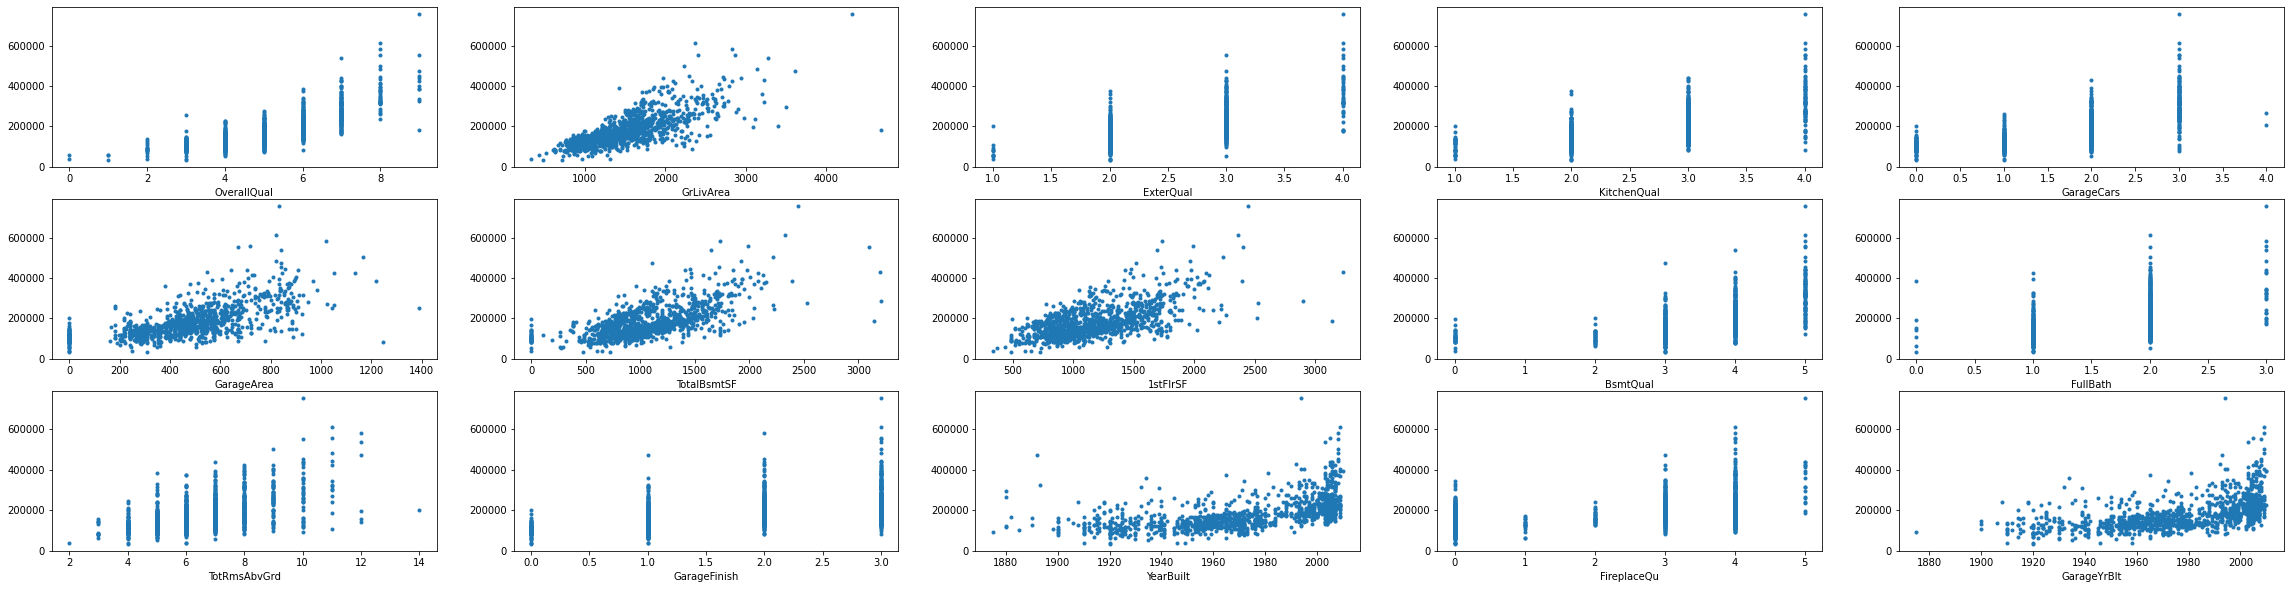

In [29]:
display(x2_train, y2_train, largest_corrs_v2, axis_v2)

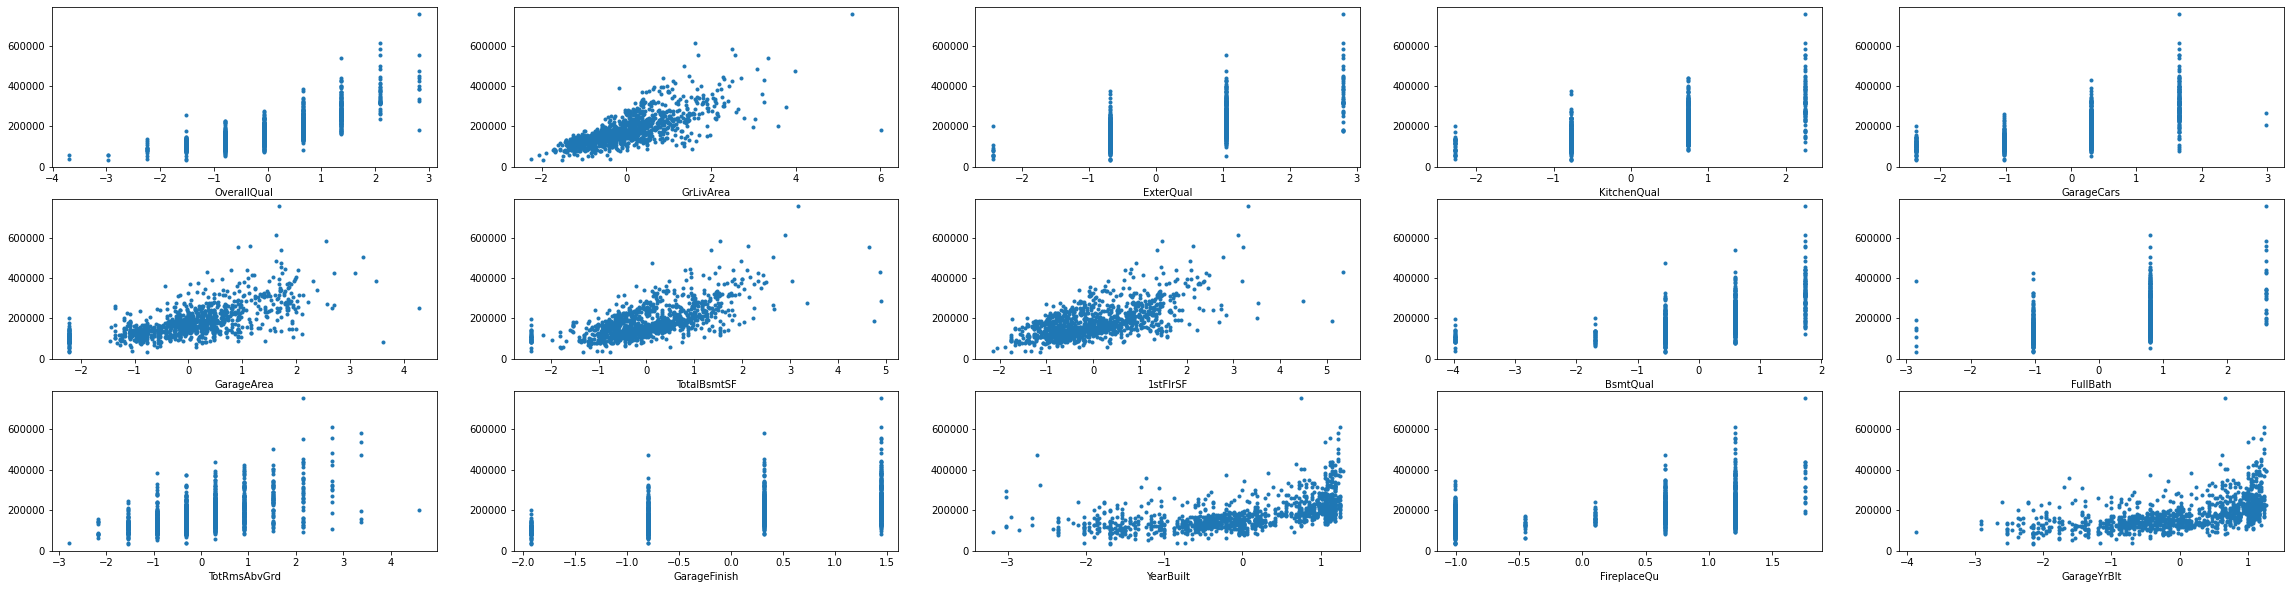

In [30]:
display(x3_train, y3_train, largest_corrs_v3, axis_v3)

In [ ]:
# Figure ou the order of the coeffecients

In [ ]:
# Next steps:
# Normalize the inputs 
# 

In [ ]:
# Working with ordered categorical values:
# Introduce splines at each of the categoricals

In [ ]:
# TODO: Years are screwy
# None of the XVARS are properly scaled
# None of  the data points are weighted


In [ ]:
row_num = 0
while row_num < len(cols) - 1:    
    pp = sns.pairplot(data=hd, y_vars=['SalePrice'], x_vars=cols[row_num:min(row_num + 10, len(cols)-1)])
    row_num += 10